In [1]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random
import matplotlib.pyplot as plt
import math

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER



### Split Training Dataset into Train and Validation Datasets

In [3]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating,1])

random.shuffle(dataset)

X = [values[0:3] for values in dataset]
y = [values[-1] for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


In [4]:
bookCount = defaultdict(int)
readerCount = defaultdict(int)
totalRead = 0

# Count the num of times a book is read, and aggregate the total num of reads
for user,book,_ in readCSV("assignment1/train_Interactions.csv"):
  bookCount[book] += 1
  readerCount[user] += 1
  totalRead += 1

print("Total num of books: {}".format(len(bookCount)))    
print("Total num of readers: {}".format(len(readerCount))) 
print("Total num of reads: {}".format(totalRead))

Total num of books: 7170
Total num of readers: 11357
Total num of reads: 200000


### Generate lists and sets for Similarity Calculations

#### Jaccard Similarity between Books

Jsim(i,j) = Intersection(U_i, U_j)/ Union(U_i, U_j)  

where U_i, U_j are set of readers who have read book i and book j  

#### Pearson Similarity between Books


Psim(i,j) = Sum_Product_crij((R_u_i-AR_u), (R_u_j-AR_u))/ SqRt(Sum_crij(Sq(R_u_i-AR_u)))SqRt(Sum_crij(Sq(R_u_j-AR_u)))  

where 
* crij - the set of readers who have read both book i and j  
* R_u_i = Rating that reader u gives book i  
* AR_u = Average rating given by reader u  





In [5]:
user_Books_full = defaultdict(set)  # Set of (user, books_read)
user_Books_Ratings_full = defaultdict(set)  # Set of (user, set(book_read, rating))
book_Readers_full = defaultdict(set)  # Set of (book, readers)
book_ids=[]
reader_ids=[]

i=0
for user,book,rating in X:
  if i % 5000 == 0:
      print ('.', end='')
  i += 1

  user_Books_full[user].add(book)
  user_Books_Ratings_full[user].add((book,rating))
  book_Readers_full[book].add(user)
  if book not in book_ids:
        book_ids.append(book)
  if user not in reader_ids:
        reader_ids.append(user)

........................................

In [7]:
print(len(reader_ids), len(book_ids))

11357 7170


In [8]:
user_Books_train = defaultdict(set)
user_Books_Ratings_train = defaultdict(set)
book_Readers_train = defaultdict(set)
book_Ratings_train = defaultdict(set)

for user,book,rating in Xtrain:
  user_Books_train[user].add(book)
  user_Books_Ratings_train[user].add((book,rating))
  book_Readers_train[book].add(user)
  book_Ratings_train[book].add(rating)


In [9]:
len(user_Books_train),len(user_Books_Ratings_train),len(book_Readers_train),len(book_Ratings_train)

(11357, 11357, 7170, 7170)

## Data Composition of Xtrain

Some of the readers have very few datapoints. We need to augment them.

<function matplotlib.pyplot.show>

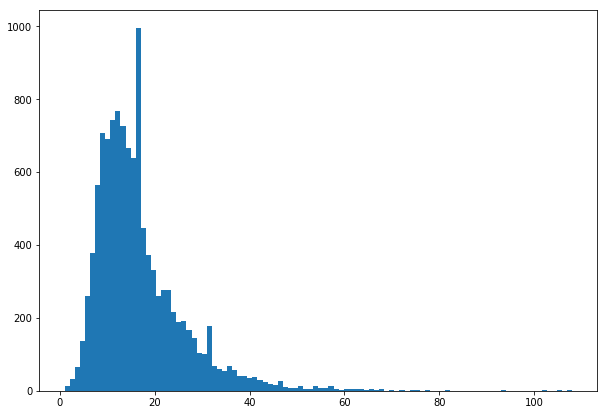

In [10]:
uCount = defaultdict(int)
# Count the num of times a book is read, and aggregate the total num of reads
for user,book,rating in Xtrain:
  uCount[user] += 1

counts = []
for id, count in  uCount.items():
    counts.append(count)

data = numpy.array(counts).T
plt.figure(figsize=(10,7))
plt.hist(data, bins=100)
plt.show    

### Create a validation dataset of alternating read and unread books per user

In [17]:
def unread_books(user, read_books, n):
    # Find n random unread books for a specific user
    
    books = []
    for i in range(n):
        book = random.choice(book_ids)  # pick a book from full library
        while book in read_books:
            book = random.choice(book_ids) 
        books.append(book)
    return books

In [101]:
Xvalid_full = []
yvalid_full = []

# To augment the validation dataset, for every read reader-book pair, generate one unread reader-book pair
for value in zip(Xvalid,yvalid):
    x,read = value
    user = x[0]
    book = x[1]
    Xvalid_full.append([user, book])
    yvalid_full.append(read)
    
    books = unread_books(user, user_Books_full[user],1)
    Xvalid_full.append([user, books[0]])
    yvalid_full.append(0)
    
Xtrain_full = []
ytrain_full = []

# To augment the training dataset, for every read reader-book pair, generate two unread reader-book pair
for value in zip(Xtrain,ytrain):
    x,read = value
    user = x[0]
    book = x[1]
    Xtrain_full.append([user, book])
    ytrain_full.append(read)
    
    num_reads = len(user_Books_train[user])
    if num_reads < 20:
        augment = int(20*2/num_reads)
        books = unread_books(user, user_Books_full[user],augment)
        for book in books:
            Xtrain_full.append([user, book])
            ytrain_full.append(0)
    else:
        books = unread_books(user, user_Books_full[user],1)
        Xtrain_full.append([user, books[0]])
        ytrain_full.append(0)



In [102]:
print(ytrain_full[:10], len(ytrain_full))

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1] 569168


<function matplotlib.pyplot.show>

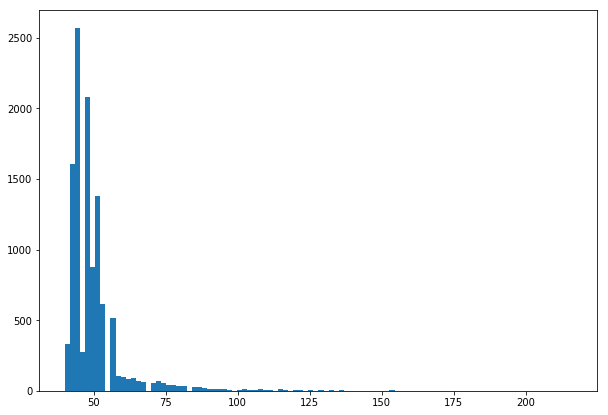

In [103]:
uCount = defaultdict(int)
# Count the num of times a book is read, and aggregate the total num of reads
for user,book in Xtrain_full:
  uCount[user] += 1

counts = []
for id, count in  uCount.items():
    counts.append(count)

data = numpy.array(counts).T
plt.figure(figsize=(10,7))
plt.hist(data, bins=100)
plt.show   

In [24]:
def list_pad(l, n):
    # if len(l) > n, the method truncates the list l to length n 
    # if n > len(l), the method pads list l with zero up to length n 
    return l[:n] + [0]*(n-len(l))

def find_rating(reader,book):
    rating = 0
    for b, rating in user_Books_Ratings_train[reader]:
        if book == b:
            return int(rating)
    return int(rating)

def average_rating(reader):
    ratings = []
    for _, rating in user_Books_Ratings_train[reader]:
        ratings.append(int(rating))
    
    if len(ratings) == 0:
        return 0
    
    return sum(ratings)/len(ratings)

"""
Jaccard Similarity
"""

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

"""
When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def items_jsim(book1, book2):
    # generate readers set for the 2 books based on train dataset
    s1 = book_Readers_train[book1]
    s2 = book_Readers_train[book2]
    return Jaccard(s1, s2)

def users_jsim(reader1, reader2):
    # generate Books set for the 2 readers based on train dataset
    s1 = user_Books_train[reader1]
    s2 = user_Books_train[reader2]
    return Jaccard(s1, s2)

def jsim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to book b
    # and return Jaccard(b, book) in descending order
    jsims = []
    
    # Go through the books read by reader r
    for other_book in user_Books_train[r]:
        if b == other_book: 
           continue   # skip if the book is b
        jsim = items_jsim(b, other_book)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  

def jsim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Jaccard(r, reader) in descending order
    jsims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        jsim = users_jsim(r, reader)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  


def jaccard_predict(user, book, threshold):
    """
    user_jsims = jsim_mostSimilar_users(book,user)
    if len(user_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = user_jsims[0]
    """    
    book_jsims = jsim_mostSimilar_items(user,book)
    if len(book_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = book_jsims[0]
        
    if max_jsim > threshold:
        predict = True
    else:
        predict = False
    return predict, max_jsim

"""
Pearson Similarity

When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def users_Pearson(r1,r2):
    
    books_r1 = set([])
    ratings_r1 = []
    
    for book,rating in user_Books_Ratings_train[r1]:
        # print (book,rating)
        books_r1.add(book)
        ratings_r1.append(int(rating))
        
    if len(ratings_r1) == 0:
        avRating_r1 = 0
    else:
        avRating_r1 = sum(ratings_r1)/len(ratings_r1)
        
    # print(books_r1)
    # print(avRating_r1)
    
    books_r2 = set([])
    ratings_r2 = []
    
    for book,rating in user_Books_Ratings_train[r2]:
        # print (book,rating)
        books_r2.add(book)
        ratings_r2.append(int(rating))
        
    if len(ratings_r2) == 0:
        avRating_r2 = 0
    else:
        avRating_r2 = sum(ratings_r2)/len(ratings_r2)  
    
    # print(books_r2)
    # print(avRating_r2)
        
    common = books_r1.intersection(books_r2)
    if len(common) == 0:  # return psim=0 if no common book
        return 0
        
    # print(common)
    
    sumProducts = []
    sumSq_R1 = []
    sumSq_R2 = []
    for book in common:
        pR_r1 = find_rating(r1,book) - avRating_r1
        pR_r2 = find_rating(r2,book) - avRating_r2
        # print(find_rating(r1,book), pR_r1)
        # print(find_rating(r2,book), pR_r2)
        sumProducts.append(pR_r1*pR_r2)
        sumSq_R1.append(pR_r1**2)
        sumSq_R2.append(pR_r2**2)
        
    if sum(sumSq_R1) == 0 or sum(sumSq_R2) == 0:
        return 0
        
    # print(sumProducts)
    # print(sumSq_R1)
    # print(sumSq_R2)
    
    psim = sum(sumProducts)/math.sqrt(sum(sumSq_R1)*sum(sumSq_R2))
    return psim

def items_Pearson(b1,b2):
    
    # Create a set of common readers for book b1 and b2
    readers_b1 = set([])
    for reader in book_Readers_train[b1]:
        readers_b1.add(reader)
        
    readers_b2 = set([])
    for reader in book_Readers_train[b2]:
        readers_b2.add(reader)
        
    common = readers_b1.intersection(readers_b2)
    if len(common) == 0:  # return psim=0 if no common readers
        return 0
        
    # print(common)
    
    sumProducts = []
    sumSq_R1 = []
    sumSq_R2 = []
    for reader in common:
        avRating = average_rating(reader)
        # print(avRating)
        pR_b1 = find_rating(reader,b1) - avRating
        pR_b2 = find_rating(reader,b2) - avRating
        # print(find_rating(reader,b1), pR_b1)
        # print(find_rating(reader,b2), pR_b2)
        sumProducts.append(pR_b1*pR_b2)
        sumSq_R1.append(pR_b1**2)
        sumSq_R2.append(pR_b2**2)
        
    if sum(sumSq_R1) == 0 or sum(sumSq_R2) == 0:
        return 0
        
    # print(sumProducts)
    # print(sumSq_R1)
    # print(sumSq_R2)
    
    psim = sum(sumProducts)/math.sqrt(sum(sumSq_R1)*sum(sumSq_R2))
    return psim

def psim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Pearson(r, reader) in descending order
    psims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        psim = users_Pearson(r, reader)
        # print (reader, psim)
        psims.append(psim)
       
    psims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return psims  

def psim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to the book b
    # and return Pearson(b, book) in descending order
    psims = []
    
    # Go through the books read by reader r 
    for book in user_Books_train[r]:
        if book == b: 
           continue   # skip if the book is b
        psim = items_Pearson(b, book)
        # print (book, psim)
        psims.append(psim)
       
    psims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return psims  

In [104]:
U_Jsims_train = []
U_Psims_train = []
B_Jsims_train = []
B_Psims_train = []

U_Jsims_valid = []
U_Psims_valid = []
B_Jsims_valid = []
B_Psims_valid = []

i=0
for u,b in Xtrain_full:
    if i % 10000 == 0:
        print ('.', end='')
    i += 1
    
    U_Jsims_train.append(list_pad(jsim_mostSimilar_users(b,u),8))
    U_Psims_train.append(list_pad(psim_mostSimilar_users(b,u),8))    
    B_Jsims_train.append(list_pad(jsim_mostSimilar_items(u,b),8))
    B_Psims_train.append(list_pad(psim_mostSimilar_items(u,b),8))
    
print ('\n')
i=0
for u,b in Xvalid_full:
    if i % 10000 == 0:
        print ('.', end='')
    i += 1
    U_Jsims_valid.append(list_pad(jsim_mostSimilar_users(b,u),8))
    U_Psims_valid.append(list_pad(psim_mostSimilar_users(b,u),8))    
    B_Jsims_valid.append(list_pad(jsim_mostSimilar_items(u,b),8)) 
    B_Psims_valid.append(list_pad(psim_mostSimilar_items(u,b),8))

.........................................................

..

## (4) Logistic Regression Model - Popularity Only

Start simple:

X.theta = y

where X = [popularity], popularity= (times a book is read)/(total num of reads)

Accuracy = 0.65

In [105]:
X_train = [[1,bookCount[x]/totalRead] for _,x in Xtrain_full]
y_train = ytrain_full

X_valid = [[1,bookCount[x]/totalRead] for _,x in Xvalid_full]
y_valid = yvalid_full

print(X_train[:10])

[[1, 0.000235], [1, 6.5e-05], [1, 6e-05], [1, 0.00012], [1, 9e-05], [1, 0.0006], [1, 0.00022], [1, 3e-05], [1, 0.00012], [1, 0.000365]]


In [106]:
lambs = [1e-6, 7e-6, 8e-6, 9e-6, 1e-5, 1.2e-5,1e-4, 1e-3, 0.01, 0.1]

for lamb in lambs:
    print("Regularization = {}".format(lamb))
    model = linear_model.LogisticRegression(max_iter = 1000, C=lamb, class_weight='balanced',solver='liblinear')
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    print("Training:")
    calc_model_stats(train_pred,y_train)

    print("Validation:")
    calc_model_stats(valid_pred,y_valid)
    
    print("\n")

Regularization = 1e-06
Training:
Accuracy: 0.333822351221432
Validation:
Accuracy: 0.5


Regularization = 7e-06
Training:
Accuracy: 0.333822351221432
Validation:
Accuracy: 0.5


Regularization = 8e-06
Training:
Accuracy: 0.6818900570657521
Validation:
Accuracy: 0.6617161716171617


Regularization = 9e-06
Training:
Accuracy: 0.333822351221432
Validation:
Accuracy: 0.5


Regularization = 1e-05
Training:
Accuracy: 0.6888598796840301
Validation:
Accuracy: 0.6620662066206621


Regularization = 1.2e-05
Training:
Accuracy: 0.333822351221432
Validation:
Accuracy: 0.5


Regularization = 0.0001
Training:
Accuracy: 0.333822351221432
Validation:
Accuracy: 0.5


Regularization = 0.001
Training:
Accuracy: 0.7095356731228741
Validation:
Accuracy: 0.6503150315031503


Regularization = 0.01
Training:
Accuracy: 0.7095356731228741
Validation:
Accuracy: 0.6503150315031503


Regularization = 0.1
Training:
Accuracy: 0.7095356731228741
Validation:
Accuracy: 0.6503150315031503




## (5) Logistic Regression Model - Popularity+ Books' JSim + Users' JSim

X.theta = y

where X = [book_popularity, user_similarity_1,user_similarity_2, book_similarity_1,book_similarity_2] 

book_popularity= (times a book is read)/(total num of reads)  
user_similarity_1 = Jaccard similarity of the user and the most similar user who read the book  
user_similarity_2 = Jaccard similarity of the user and the 2nd most similar user who read the book  
book_similarity_1 = Jaccard similarity of the book and the most similar book read by the reader  
book_similarity_2 = Jaccard similarity of the book and 2nd most similar book read by the reader  

and so on ...  

Accuracy = 0.693

In [107]:
X_train = []
X_valid = []

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xtrain_full, U_Jsims_train,U_Psims_train, \
                                                             B_Jsims_train,B_Psims_train):
    X_train.append([1, bookCount[b]/totalRead, user_jsims[0], user_jsims[1], user_jsims[2], user_jsims[3]])
y_train = ytrain_full

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xvalid_full, U_Jsims_valid,U_Psims_valid, \
                                                             B_Jsims_valid,B_Psims_valid):
    X_valid.append([1, bookCount[b]/totalRead, user_jsims[0], user_jsims[1], user_jsims[2], user_jsims[3]])
y_valid = yvalid_full


In [108]:
lambs = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 1e-5, 1e-4]

for lamb in lambs:
    print("Regularization = {}".format(lamb))
    model = linear_model.LogisticRegression(C=lamb, class_weight='balanced',solver='liblinear')
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    print("Training:")
    calc_model_stats(train_pred,y_train)

    print("Validation:")
    calc_model_stats(valid_pred,y_valid)
    
    print("\n")


Regularization = 1e-06
Training:
Accuracy: 0.6454930705872431
Validation:
Accuracy: 0.64001400140014


Regularization = 2e-06
Training:
Accuracy: 0.7426454052230624
Validation:
Accuracy: 0.6744674467446745


Regularization = 3e-06
Training:
Accuracy: 0.7921720827593962
Validation:
Accuracy: 0.681968196819682


Regularization = 4e-06
Training:
Accuracy: 0.8234897253534984
Validation:
Accuracy: 0.6826682668266827


Regularization = 5e-06
Training:
Accuracy: 0.8443886515053551
Validation:
Accuracy: 0.67996799679968


Regularization = 6e-06
Training:
Accuracy: 0.8588975487026678
Validation:
Accuracy: 0.677967796779678


Regularization = 1e-05
Training:
Accuracy: 0.8889291035335788
Validation:
Accuracy: 0.6614161416141614


Regularization = 0.0001
Training:
Accuracy: 0.9174303544823321
Validation:
Accuracy: 0.607960796079608




In [114]:
X_train = []
X_valid = []

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xtrain_full, U_Jsims_train,U_Psims_train, \
                                                             B_Jsims_train,B_Psims_train):
    X_train.append([1, bookCount[b]/totalRead, \
                    # readerCount[u]/totalRead, \
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    book_jsims[0], book_jsims[1]])
y_train = ytrain_full

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xvalid_full, U_Jsims_valid,U_Psims_valid, \
                                                             B_Jsims_valid,B_Psims_valid):
    X_valid.append([1, bookCount[b]/totalRead, \
                    # readerCount[u]/totalRead, \
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    book_jsims[0], book_jsims[1]])
y_valid = yvalid_full

In [115]:
lambs = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 7e-6, 9e-6, 1e-5, 1.1e-5, 1.2e-5, 1.3e-5, 1.4e-5, 1e-4]

for lamb in lambs:
    print("Regularization = {}".format(lamb))
    model = linear_model.LogisticRegression(C=lamb, class_weight='balanced',solver='liblinear')
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    print("Training:")
    calc_model_stats(train_pred,y_train)

    print("Validation:")
    calc_model_stats(valid_pred,y_valid)
    
    print("\n")

Regularization = 1e-06
Training:
Accuracy: 0.6516107722148821
Validation:
Accuracy: 0.6413641364136413


Regularization = 2e-06
Training:
Accuracy: 0.7494887274056167
Validation:
Accuracy: 0.6756675667566757


Regularization = 3e-06
Training:
Accuracy: 0.8043354510443314
Validation:
Accuracy: 0.6851685168516851


Regularization = 4e-06
Training:
Accuracy: 0.8381022826300846
Validation:
Accuracy: 0.6882688268826883


Regularization = 5e-06
Training:
Accuracy: 0.8609092570207741
Validation:
Accuracy: 0.6833683368336834


Regularization = 7e-06
Training:
Accuracy: 0.8891926461080033
Validation:
Accuracy: 0.6753675367536753


Regularization = 9e-06
Training:
Accuracy: 0.9057589323363225
Validation:
Accuracy: 0.6666666666666666


Regularization = 1e-05
Training:
Accuracy: 0.9115955218845754
Validation:
Accuracy: 0.6623162316231623


Regularization = 1.1e-05
Training:
Accuracy: 0.9165395805807776
Validation:
Accuracy: 0.6590659065906591


Regularization = 1.2e-05
Training:
Accuracy: 0.920617

## Kaggle Submission, Accuracy=0.695, User_Name='Luke Liem'

In [116]:
users=[]
books=[]
X_test=[]

model = linear_model.LogisticRegression(C=4e-6, class_weight='balanced',solver='liblinear')
model.fit(X_train, y_train)

predictions = open("assignment1/predictions_Read.txt", 'w')
for l in open("assignment1/pairs_Read.txt"):

    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    
    u,b = l.strip().split('-')
    
    users.append(u)
    books.append(b)
    
    # Predict using Jaccard similarity
    user_jsims = list_pad(jsim_mostSimilar_users(b,u),8)
    book_jsims = list_pad(jsim_mostSimilar_items(u,b),8)
    X_test.append([1, bookCount[b]/totalRead, \
                    # readerCount[u]/totalRead, \
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    book_jsims[0], book_jsims[1]])

test_pred = model.predict(X_test)

for u,b,pred in zip(users,books,test_pred):
        predictions.write(u + '-' + b + "," + str(pred) + "\n")

predictions.close()

## (7) Logistic Regression Model - Popularity+ Books' JSim + Users' JSim

X.theta = y

where X = [book_popularity, user_Jsim_1,user_Jsim_2, book_Jsim_1,book_Jsim_2, user_Psim_1,user_Psim_2] 

book_popularity= (times a book is read)/(total num of reads)  
user_Jsim_1 = Jaccard similarity of the user and the most similar user who read the book  
user_Jsim_2 = Jaccard similarity of the user and the 2nd most similar user who read the book  
book_Jsim_1 = Jaccard similarity of the book and the most similar book read by the reader  
book_Jsim_2 = Jaccard similarity of the book and 2nd most similar book read by the reader 
user_Psim_1 = Pearson similarity of the user and the most similar user who read the book  
user_Psim_2 = Pearson similarity of the user and the 2nd most similar user who read the book 

and so on ...  

The Pearson Similarity seems pretty useless!!!

Accuracy = 0.622

In [112]:
X_train = []
X_valid = []

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xtrain_full, U_Jsims_train,U_Psims_train, \
                                                             B_Jsims_train,B_Psims_train):
    X_train.append([1, bookCount[b]/totalRead, readerCount[u]/totalRead,
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    user_jsims[5],user_jsims[6],user_jsims[7], \
                    book_jsims[0], book_jsims[1], \
#                    user_psims[0],user_psims[1],user_psims[2],user_psims[3],user_psims[4], \
                   ])
y_train = ytrain_full

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xvalid_full, U_Jsims_valid,U_Psims_valid, \
                                                             B_Jsims_valid,B_Psims_valid):
    X_valid.append([1, bookCount[b]/totalRead, readerCount[u]/totalRead,
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    user_jsims[5],user_jsims[6],user_jsims[7], \
                    book_jsims[0], book_jsims[1], \
#                    user_psims[0],user_psims[1],user_psims[2],user_psims[3],user_psims[4], \
                   ])
y_valid = yvalid_full

In [113]:
# lambs = [1e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 1e-3, 1.5e-3, 2e-3, 2.5e-3, 5e-3, 0.01, 0.025, 0.05]
# [1, bookCount[b]/totalRead, readerCount[u]/totalRead,
#                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
#                    book_jsims[0],book_jsims[1], \
#                   ])
# Regularization = 5e-06; Accuracy: 0.682018201820182

lambs = [1e-8, 1e-7, 1e-6, 1.2e-6, 1.3e-6,  1.4e-6,  1.5e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05]

for lamb in lambs:

    print("Regularization = {}".format(lamb))
    model = linear_model.LogisticRegression(max_iter = 1000, C=lamb, class_weight='balanced',solver='liblinear')
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    print("Training:")
    calc_model_stats(train_pred,y_train)

    print("Validation:")
    calc_model_stats(valid_pred,y_valid)
    
    print("\n")

Regularization = 1e-08
Training:
Accuracy: 0.333822351221432
Validation:
Accuracy: 0.5


Regularization = 1e-07
Training:
Accuracy: 0.5414868720658926
Validation:
Accuracy: 0.5915591559155916


Regularization = 1e-06
Training:
Accuracy: 0.7000323278891294
Validation:
Accuracy: 0.6587658765876587


Regularization = 1.2e-06
Training:
Accuracy: 0.7276463188373204
Validation:
Accuracy: 0.6695169516951696


Regularization = 1.3e-06
Training:
Accuracy: 0.7402348691423271
Validation:
Accuracy: 0.6729672967296729


Regularization = 1.4e-06
Training:
Accuracy: 0.7521557782587918
Validation:
Accuracy: 0.6764176417641764


Regularization = 1.5e-06
Training:
Accuracy: 0.7629452112557277
Validation:
Accuracy: 0.6793679367936794


Regularization = 1e-05
Training:
Accuracy: 0.9417201950917831
Validation:
Accuracy: 0.6431643164316432


Regularization = 0.0001
Training:
Accuracy: 0.9611731509852979
Validation:
Accuracy: 0.5941094109410942


Regularization = 0.001
Training:
Accuracy: 0.964282953363506
V

## Ensembling


In [129]:
X_train = [[1,bookCount[x]/totalRead] for _,x in Xtrain_full]
y_train = ytrain_full

model1 = linear_model.LogisticRegression(C=1e-05, class_weight='balanced',solver='liblinear')
model1.fit(X_train, y_train)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
X_train = []

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xtrain_full, U_Jsims_train,U_Psims_train, \
                                                             B_Jsims_train,B_Psims_train):
    X_train.append([1, bookCount[b]/totalRead, \
                    # readerCount[u]/totalRead, \
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    book_jsims[0], book_jsims[1]])
y_train = ytrain_full

model2 = linear_model.LogisticRegression(C=4e-6, class_weight='balanced',solver='liblinear')
model2.fit(X_train, y_train)


LogisticRegression(C=4e-06, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
X_train = []

for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xtrain_full, U_Jsims_train,U_Psims_train, \
                                                             B_Jsims_train,B_Psims_train):
    X_train.append([1, bookCount[b]/totalRead, readerCount[u]/totalRead,
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    user_jsims[5],user_jsims[6],user_jsims[7], \
                    book_jsims[0], book_jsims[1], \
#                    user_psims[0],user_psims[1],user_psims[2],user_psims[3],user_psims[4], \
                   ])
y_train = ytrain_full

model3 = linear_model.LogisticRegression(C=1.5e-06, class_weight='balanced',solver='liblinear')
model3.fit(X_train, y_train)

LogisticRegression(C=1.5e-06, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [131]:
X_valid = [[1,bookCount[x]/totalRead] for _,x in Xvalid_full]
y_valid = yvalid_full

valid_pred1 = model1.predict(X_valid)

In [132]:
X_valid = []
for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xvalid_full, U_Jsims_valid,U_Psims_valid, \
                                                             B_Jsims_valid,B_Psims_valid):
    X_valid.append([1, bookCount[b]/totalRead, \
                    # readerCount[u]/totalRead, \
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    book_jsims[0], book_jsims[1]])
y_valid = yvalid_full

valid_pred2 = model2.predict(X_valid)

In [136]:
X_valid = []
for (u,b),user_jsims,user_psims,book_jsims,book_psims in zip(Xvalid_full, U_Jsims_valid,U_Psims_valid, \
                                                             B_Jsims_valid,B_Psims_valid):
    X_valid.append([1, bookCount[b]/totalRead, readerCount[u]/totalRead,
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    user_jsims[5],user_jsims[6],user_jsims[7], \
                    book_jsims[0], book_jsims[1], \
#                    user_psims[0],user_psims[1],user_psims[2],user_psims[3],user_psims[4], \
                   ])
y_valid = yvalid_full

valid_pred3 = model3.predict(X_valid)

In [141]:
ensemble_pred = [1 if (y1+y2+y3)>1 else 0 for y1,y2,y3 in zip(valid_pred1,valid_pred2,valid_pred3)]

calc_model_stats(ensemble_pred,y_valid)

Accuracy: 0.6912191219121913


## Kaggle Submission, Accuracy=0.698, User_Name='Luke Liem'

In [143]:
users=[]
books=[]
X_test1=[]
X_test2=[]
X_test3=[]

# model = linear_model.LogisticRegression(C=4e-6, class_weight='balanced',solver='liblinear')
# model.fit(X_train, y_train)

predictions = open("assignment1/predictions_Read.txt", 'w')
for l in open("assignment1/pairs_Read.txt"):

    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    
    u,b = l.strip().split('-')
    
    users.append(u)
    books.append(b)
    
    # Predict using Jaccard similarity
    user_jsims = list_pad(jsim_mostSimilar_users(b,u),8)
    book_jsims = list_pad(jsim_mostSimilar_items(u,b),8)
    X_test1.append([1, bookCount[b]/totalRead])
    X_test2.append([1, bookCount[b]/totalRead, \
                    # readerCount[u]/totalRead, \
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    book_jsims[0], book_jsims[1]])
    X_test3.append([1, bookCount[b]/totalRead, readerCount[u]/totalRead,
                    user_jsims[0],user_jsims[1],user_jsims[2],user_jsims[3],user_jsims[4], \
                    user_jsims[5],user_jsims[6],user_jsims[7], \
                    book_jsims[0], book_jsims[1], \
                   ])

test_pred1 = model1.predict(X_test1)
test_pred2 = model2.predict(X_test2)
test_pred3 = model3.predict(X_test3)

ensemble_pred = [1 if (y1+y2+y3)>1 else 0 for y1,y2,y3 in zip(test_pred1,test_pred2,test_pred3)]

for u,b,pred in zip(users,books,ensemble_pred):
        predictions.write(u + '-' + b + "," + str(pred) + "\n")

predictions.close()